# Predictive Analysis on Bigmart Outlet Sales

# Importing Libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [106]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Load the dataset

In [107]:
data = pd.read_csv("Tech_Train.csv")
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Basic info 

In [108]:
data.shape

(8523, 12)

In [109]:
data.size

102276

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [111]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [112]:
data.apply(lambda x: len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

# Preprocessing

# Handling missing data

In [113]:
missing_values = data.isnull().sum()
print(missing_values)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [114]:
cat_col=[]
for x in data.dtypes.index:
    if data.dtypes[x]=='object':
        cat_col.append(x)
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [115]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')
cat_col

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [116]:
# print the categorical columns
for col in cat_col:
    print(col)
    print(data[col].value_counts())
    print()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int6

In [117]:
# fill the missing values
item_weight_mean = data.pivot_table(values = "Item_Weight", index = 'Item_Identifier')
item_weight_mean

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [118]:
miss_bool = data['Item_Weight'].isnull()
miss_bool

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Item_Weight, Length: 8523, dtype: bool

In [119]:
for i, item in enumerate(data['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean:
            data['Item_Weight'][i] = item_weight_mean.loc[item]['Item_Weight']
        else:
            data['Item_Weight'][i] = np.mean(data['Item_Weight'])


In [120]:
data['Item_Weight'].isnull().sum()

0

In [121]:
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [122]:
miss_bool = data['Outlet_Size'].isnull()
data.loc[miss_bool, 'Outlet_Size'] = data.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [123]:
data['Outlet_Size'].isnull().sum()

0

In [124]:
sum(data['Item_Visibility']==0)

526

In [125]:
# replace zeros with mean
data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].mean()], inplace=True)
sum(data['Item_Visibility']==0)

0

In [126]:
# combine item fat content
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Creation of New Attributes

In [127]:
data['New_Item_Type'] = data['Item_Identifier'].apply(lambda x: x[:2])
data['New_Item_Type']

0       FD
1       DR
2       FD
3       FD
4       NC
        ..
8518    FD
8519    FD
8520    NC
8521    FD
8522    DR
Name: New_Item_Type, Length: 8523, dtype: object

In [128]:
data['New_Item_Type'] = data['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['New_Item_Type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: New_Item_Type, dtype: int64

In [129]:
data.loc[data['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
data['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

In [130]:
# create small values for establishment year
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

In [131]:
data['Outlet_Years']

0       14
1        4
2       14
3       15
4       26
        ..
8518    26
8519    11
8520     9
8521     4
8522    16
Name: Outlet_Years, Length: 8523, dtype: int64

In [132]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_Item_Type,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


# Exploratory Data Analysis

<AxesSubplot:xlabel='Item_Weight', ylabel='Density'>

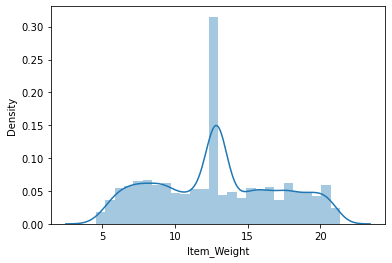

In [133]:
sns.distplot(data['Item_Weight'])

The distribution plot shows the frequency or count of different values of 'Item_Weight' along the x-axis, while the y-axis represents the probability density or normalized count.Plot is approximately symmetric and bell-shaped

<AxesSubplot:xlabel='Item_Visibility', ylabel='Density'>

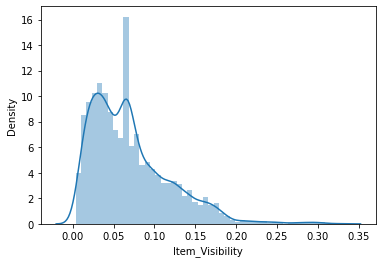

In [134]:
sns.distplot(data['Item_Visibility'])

The distribution plot shows the frequency or count of different values of 'Item_Visibility' along the x-axis, while the y-axis represents the probability density or normalized count.The plot is skewed to the left, it suggests a concentration of higher 'Item_Visibility' values with a long tail of lower values.

<AxesSubplot:xlabel='Item_MRP', ylabel='Density'>

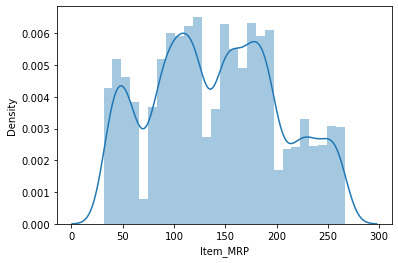

In [135]:
sns.distplot(data['Item_MRP'])

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

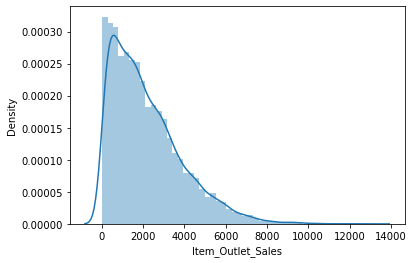

In [136]:
sns.distplot(data['Item_Outlet_Sales'])

In [137]:
data['Item_Outlet_Sales'] = np.log(1+data['Item_Outlet_Sales'])

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

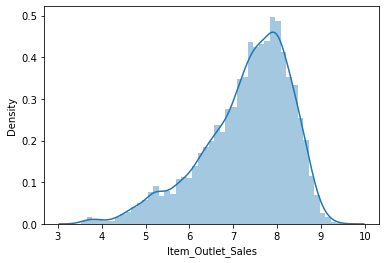

In [138]:
sns.distplot(data['Item_Outlet_Sales'])

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

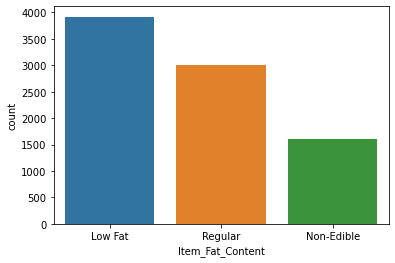

In [139]:
sns.countplot(data["Item_Fat_Content"])

[Text(0, 0, 'Dairy'),
 Text(1, 0, 'Soft Drinks'),
 Text(2, 0, 'Meat'),
 Text(3, 0, 'Fruits and Vegetables'),
 Text(4, 0, 'Household'),
 Text(5, 0, 'Baking Goods'),
 Text(6, 0, 'Snack Foods'),
 Text(7, 0, 'Frozen Foods'),
 Text(8, 0, 'Breakfast'),
 Text(9, 0, 'Health and Hygiene'),
 Text(10, 0, 'Hard Drinks'),
 Text(11, 0, 'Canned'),
 Text(12, 0, 'Breads'),
 Text(13, 0, 'Starchy Foods'),
 Text(14, 0, 'Others'),
 Text(15, 0, 'Seafood')]

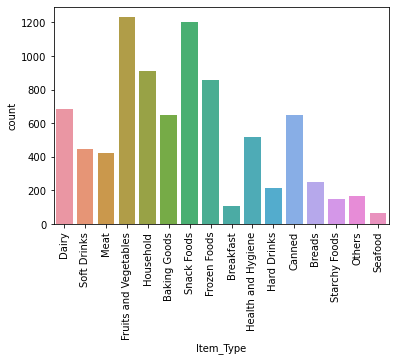

In [140]:
# plt.figure(figsize=(15,5))
l = list(data['Item_Type'].unique())
chart = sns.countplot(data["Item_Type"])
chart.set_xticklabels(labels=l, rotation=90)

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

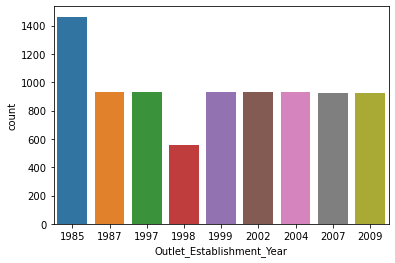

In [141]:
sns.countplot(data['Outlet_Establishment_Year'])

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

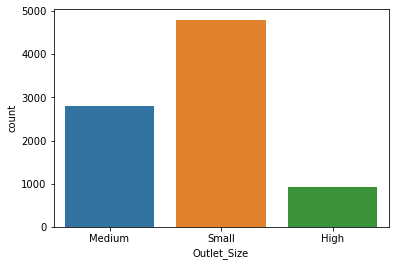

In [142]:
sns.countplot(data['Outlet_Size'])

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

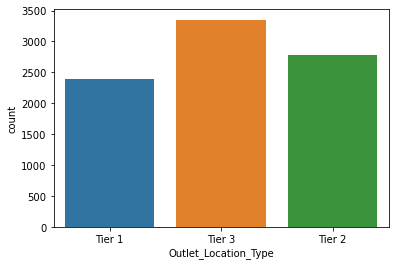

In [143]:
sns.countplot(data['Outlet_Location_Type'])

<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

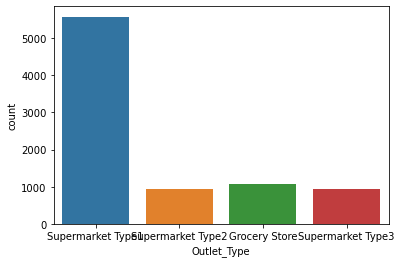

In [144]:
sns.countplot(data['Outlet_Type'])

# Coorelation Matrix

<AxesSubplot:>

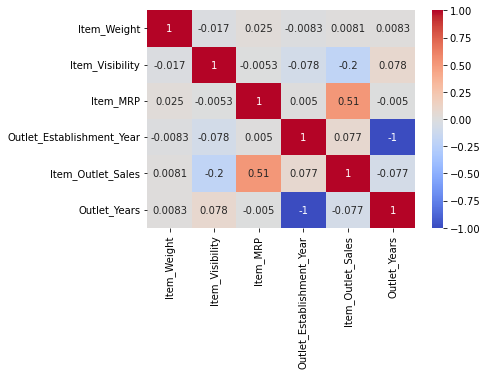

In [145]:
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [146]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_Item_Type,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.225808,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.096776,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.648868,Food,14
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,6.597664,Food,15
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.903451,Non-Consumable,26


# Label Encoding

In [147]:
le = LabelEncoder()
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type']
for col in cat_col:
    data[col] = le.fit_transform(data[col])

# Onehot Encoding

In [148]:
data = pd.get_dummies(data, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'])
data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Years,Outlet,...,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,New_Item_Type_0,New_Item_Type_1,New_Item_Type_2
0,FDA15,9.30,0.016047,4,249.8092,OUT049,1999,8.225808,14,9,...,1,0,0,0,1,0,0,0,1,0
1,DRC01,5.92,0.019278,14,48.2692,OUT018,2009,6.096776,4,3,...,0,0,1,0,0,1,0,1,0,0
2,FDN15,17.50,0.016760,10,141.6180,OUT049,1999,7.648868,14,9,...,1,0,0,0,1,0,0,0,1,0
3,FDX07,19.20,0.066132,6,182.0950,OUT010,1998,6.597664,15,0,...,0,0,1,1,0,0,0,0,1,0
4,NCD19,8.93,0.066132,9,53.8614,OUT013,1987,6.903451,26,1,...,0,0,1,0,1,0,0,0,0,1


# Spliting

In [149]:
X = data.drop(columns=['Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
y = data['Item_Outlet_Sales']


# Model Training

In [150]:
def train(model, X, y):
    # train the model
    model.fit(X, y)
    
    # predict the training set
    pred = model.predict(X)
    
    # perform cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    # Calculate R^2
    r2 = r2_score(y, pred)
    
    print("Model Report")
    print("MSE:",mean_squared_error(y,pred))
    print("CV Score:", cv_score)
    print("R^2:", r2)

model = LinearRegression(normalize=True)
train(model, X, y)

Model Report
MSE: 0.2880065032501795
CV Score: 0.28911084886374205
R^2: 0.7205267398812387


# Linear Regression

Model Report
MSE: 0.2880065032501795
CV Score: 0.28911084886374205
R^2: 0.7205267398812387


<AxesSubplot:title={'center':'Model Coefficients'}>

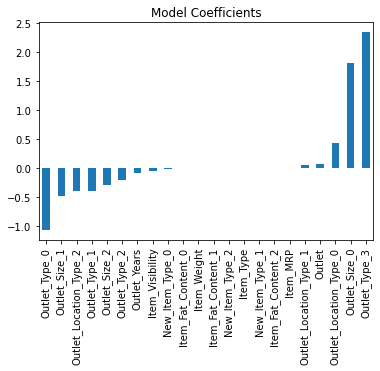

In [151]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
model = LinearRegression(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

# Regularized Linear Regression

Model Report
MSE: 0.4280298560568369
CV Score: 0.428928925156264
R^2: 0.584652089621543


<AxesSubplot:title={'center':'Model Coefficients'}>

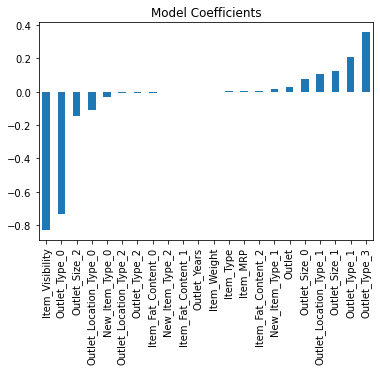

In [152]:
model = Ridge(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

# RandomForestRegressor

Model Report
MSE: 0.04261480105402996
CV Score: 0.3103963559012366
R^2: 0.9586478178600825


<AxesSubplot:title={'center':'Feature Importance'}>

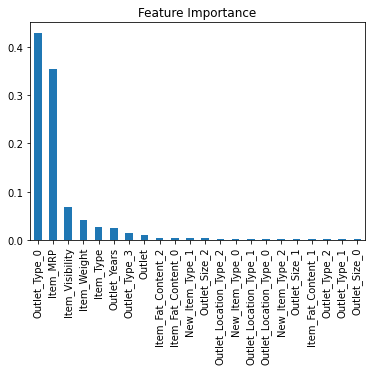

In [153]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Feature Importance")

# XGBoost

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(tree_method='approx')
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2:", r2)

Mean Squared Error: 0.309190043760339
R^2: 0.7059097534291534


# The Random Forest Regressor gave the best accuracy.